### Parameters

**wetb**: Wet bulb Air Temperature(°C) is used to measure the extent of cooling as moisture dries on a surface.

**dewpt**: Dew point Air Temperature(°C) is used to determine the temperature at which the air can no longer retain moisture. This figure should always be less than or equal to the value of the actual temperature. If air temperature cools to dew point, or the dew point rises to the current temperature then fog or clouds appear. Sourced: http://www.weatherquestions.com/What_is_dewpoint_temperature.htm

**vappr**: Vapour Pressure(hpa) 

**rhum**: Relative Humidity	describes how close the air is to saturation with moisture. Therefore a high relative humidity (100%) indicates theres more moisture in the air.


**msl**: Mean Sea Level Pressure is the atmospheric pressure recorded at sea.

#### Recurrent Neural Networks.
One of the best neural network architectures for predicting "the future", in this case future weather forecasts. Work quite well with time series data which is what I have here.

Suffer from vanishing/exploding gradients. LSTM and GRU cells used to combat this.

# Basic Exploratory Data Analysis On Entire Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from pandas.core import datetools
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

/home/gspc/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def create_connection():
    cnx2 = mysql.connector.connect(host='localhost',
                                   user='root', password='MyNewPass',
                                   database='Weather_Data')
    return cnx2

In [3]:
def select_data():
    conn = create_connection()
    cursor = conn.cursor()
    print('Extracting Data')
    query = "Select * from weather where Observation_date <= '2018-06-01 00:00:00';"
    cursor.execute(query, )
    result = cursor.fetchall()
    print('Extracted Data')
        
    cursor.close()
    conn.close()
    
    return result
    

In [4]:
def null_values(data):
    print(data.isnull().sum())

In [5]:
def change_structure(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = pd.DataFrame(data, columns=cols)
    
    null_values(data)
    data.fillna(0, inplace=True)
    return data

In [6]:
def split_time(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month.astype(np.uint8)
    data['day'] = data['date'].dt.day.astype(np.uint8)
    data['hour'] = data['date'].dt.hour.astype(np.uint8)
    
    return data

In [7]:
def generate_season(data):
    data['season'] = pd.cut(data['month'], bins=[0,1,4,7,10,14], labels=['Winter','Spring','Summer','Autumn','Winter2']).str.replace('Winter2','Winter')
    #data['season'] = pd.Categorical(list(data['season']),categories = ['Spring','Summer','Autumn','Winter'])
    return data

In [8]:
def mean_features(data):
    # mean rain, temp, windsp, windirection by year, by season
    group = ['year', 'season','month','station']
    features = ['rain', 'temp', 'wdsp', 'wddir','wetb', 'dewpt','vappr', 'rhum', 'msl']
    
    for grouping in group:
        for predictor in features:
            print('Grouping by ',grouping, ' getting average ', predictor )
            
            new_var = predictor + '_by_' + grouping
            temp = data.groupby(grouping)[predictor].mean().reset_index() 
            temp.columns = [grouping, new_var]
            data = data.merge(temp, how='left', on=grouping)
    
    null_values(data)
    
    return data

In [9]:
def remove_rhum_values(data):
    print('Removing relative humidity values <= 0')
    data = data[data['rhum'] > 0]
    
    return data

In [10]:
def plot_by_year(data):
    data = data.sort_values('year')
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Yearly Averages')
    
    plt.subplot(521)
    plt.scatter('year', 'rain_by_year', data=data, color="orange")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Rainfall Distribution')
    
    plt.subplot(522)
    plt.scatter('year', 'temp_by_year', data=data, color="green")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Temperature Distribution')

    
    plt.subplot(523)
    plt.scatter('year', 'wdsp_by_year', data=data, color="blue")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Windspeed Distribution')

    
    plt.subplot(524)
    plt.scatter('year', 'wddir_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Wind Direction Distribution')
    
    plt.subplot(525)
    plt.scatter('year', 'wetb_by_year', data=data, color="orange")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Wet Bulb Temp Distribution')
    
    plt.subplot(526)
    plt.scatter('year', 'dewpt_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Dew Point Temp Distribution')
    
    plt.subplot(527)
    plt.scatter('year', 'vappr_by_year', data=data, color="blue")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Vapour Pressure Distribution')
    
    plt.subplot(528)
    plt.scatter('year', 'rhum_by_year', data=data, color="green")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Relative Humidity Distribution')
    
    plt.subplot(529)
    plt.scatter('year', 'msl_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Mean Sea Level Pressure by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Sea Level Pressure Distribution')

    
    plt.savefig('Yearly Averages.png')

    
    plt.show()

In [11]:
def plot_by_season(data):
    data['season'] = data['season'].astype('category')
    data['season'].cat.reorder_categories(['Spring', 'Summer','Autumn', 'Winter'], inplace=True)
    data = data.sort_values('season').reset_index()
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Season Averages')
    
    plt.subplot(521)
    sns.barplot(x="season", y="rain_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Rainfall by Season')
    
    plt.subplot(522)
    sns.barplot(x="season", y="temp_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Temperature by Season')

    
    plt.subplot(523)
    sns.barplot(x="season", y="wdsp_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Windspeed by Season')

    
    plt.subplot(524)
    sns.barplot(x="season", y="wddir_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wind Direction by Season')
    
    
    plt.subplot(525)
    sns.barplot(x="season", y="wetb_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wet Bulb Temp by Season')
    
    
    plt.subplot(526)
    sns.barplot(x="season", y="dewpt_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Dew Point Temp by Season')
    
    
    plt.subplot(527)
    sns.barplot(x="season", y="vappr_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Vapour Pressure by Season')
    
    
    plt.subplot(528)
    sns.barplot(x="season", y="rhum_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Relative Humidity by Season')
    
    
    plt.subplot(529)
    sns.barplot(x="season", y="msl_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Mean Sea Level Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Sea Level Pressure by Season')

    
    plt.savefig('Seasonal Averages.png')
    
    plt.show()

In [12]:
def plot_by_station(data):
    data['station'].astype('category')
    data = data.sort_values('station')
    
    plt.figure(figsize=(20,20))
    plt.suptitle('Station Averages')
    
    plt.subplot(221)
    plt.plot('station', 'rain_by_station', data=data, color="orange")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Rainfall Distribution by Station')

    
    plt.subplot(222)
    plt.plot('station', 'temp_by_station', data=data, color="green")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Temperature Distribution by Station')

    
    plt.subplot(223)
    plt.plot('station', 'wdsp_by_station', data=data, color="blue")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Windspeed Distribution by Station')

    
    plt.subplot(224)
    plt.plot('station', 'wddir_by_station', data=data, color="red")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Wind Direction Distribution by Station')

    
    plt.savefig('Station Averages.png')
    
    plt.show()

In [13]:
def plot_by_month(data):
    data['month'].astype('category')
    data = data.sort_values('month')
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Monthly Averages')
    
    plt.subplot(521)
    plt.plot('month', 'rain_by_month', data=data, color="orange")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Rainfall Distribution by Month')

    
    plt.subplot(522)
    plt.plot('month', 'temp_by_month', data=data, color="green")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Temperature Distribution by Month')

    
    plt.subplot(523)
    plt.plot('month', 'wdsp_by_month', data=data, color="blue")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Windspeed Distribution by Month')

    
    plt.subplot(524)
    plt.plot('month', 'wddir_by_month', data=data, color="red")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wind Direction Distribution by Month')
    
    plt.subplot(525)
    plt.plot('month', 'wetb_by_year', data=data, color="orange")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wet Bulb Temp by Month')

    
    plt.subplot(526)
    plt.plot('month', 'dewpt_by_month', data=data, color="green")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Dew Point Temp by Month')

    
    plt.subplot(527)
    plt.plot('month', 'vappr_by_month', data=data, color="blue")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Vapour Pressure by Month')
    
    plt.subplot(528)
    plt.plot('month', 'rhum_by_month', data=data, color="red")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Relative Humidity by Month')
    
    plt.subplot(529)
    plt.plot('month', 'msl_by_month', data=data, color="green")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Mean Sea Level Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Sea Level Pressure by Month')
    
    plt.savefig('Monthly Averages.png')
    
    plt.show()

In [14]:
def create_sets(data):
    max_index = len(data)
    
    start_train = 0
    end_train = round(max_index//2)

    start_validation = end_train + 1
    end_validation = round(start_validation + (max_index - end_train) // 2)

    start_test = end_validation + 1
    end_test = max_index

    train = data[start_train:end_train]
    validation = data[start_validation:end_validation]
    test = data[start_test:end_test]
    
    return train, validation, test

In [15]:
def basic_numeric_analysis(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir']
    raw_data = data[cols]
    print(pd.DataFrame(raw_data.describe()))

In [16]:
def display_county_stations(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = data[cols]
    original_col_names = data.columns
    
    df = data.groupby(['county', 'station']).size().reset_index(name='Recorded Observations')
    return pd.DataFrame(df)
    

In [17]:
def rhum_vs_rain(data):
    plt.figure(figsize=(15,55))
    
    sns.lmplot('rhum', 'rain', data=data, fit_reg=False)
    plt.xlabel('Relative humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.title('Relative humidity vs. Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.savefig('Relative humidity vs. Rainfall.png')
    plt.show()

In [18]:
def rhum_vs_temp(data):
    plt.figure(figsize=(15,55))
    
    sns.lmplot('rhum', 'temp', data=data, fit_reg=False)
    plt.xlabel('Relative humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Temperature', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.title('Relative humidity vs. Temperature', fontweight='bold', color = 'orange', fontsize='14')
    plt.savefig('Relative humidity vs. Temperature.png')
    plt.show()

In [19]:
def display_feature_correlations(data):
    plt.figure(figsize=(30,30))
    plt.title('Feature Correlation', fontsize=20)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(data.corr(),square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})
    plt.savefig('Correlation.png')
    plt.show()

In [20]:
data = select_data()
data = change_structure(data)
data = remove_rhum_values(data)

Extracting Data
Extracted Data
date         0
rain         0
temp         0
wetb         0
dewpt        0
vappr        0
rhum         0
msl          0
wdsp         0
wddir        0
height       0
latitude     0
longitude    0
station      0
county       0
dtype: int64
Removing relative humidity values <= 0


In [21]:
data = split_time(data)

In [22]:
data = generate_season(data)

In [23]:
data = mean_features(data)

Grouping by  year  getting average  rain
Grouping by  year  getting average  temp
Grouping by  year  getting average  wdsp
Grouping by  year  getting average  wddir
Grouping by  year  getting average  wetb
Grouping by  year  getting average  dewpt
Grouping by  year  getting average  vappr
Grouping by  year  getting average  rhum
Grouping by  year  getting average  msl
Grouping by  season  getting average  rain
Grouping by  season  getting average  temp
Grouping by  season  getting average  wdsp
Grouping by  season  getting average  wddir
Grouping by  season  getting average  wetb
Grouping by  season  getting average  dewpt
Grouping by  season  getting average  vappr
Grouping by  season  getting average  rhum
Grouping by  season  getting average  msl
Grouping by  month  getting average  rain
Grouping by  month  getting average  temp
Grouping by  month  getting average  wdsp
Grouping by  month  getting average  wddir
Grouping by  month  getting average  wetb
Grouping by  month  getting a

In [24]:
basic_numeric_analysis(data)

              rain         temp         wetb        dewpt        vappr  \
count 3,984,090.00 3,984,090.00 3,984,090.00 3,984,090.00 3,984,090.00   
mean          0.12         9.96         8.67         7.24        10.58   
std           0.49         4.67         4.28         4.48         3.17   
min           0.00       -16.60       -49.00       -22.90         0.00   
25%           0.00         6.80         5.70         4.00         8.10   
50%           0.00        10.10         8.90         7.60        10.40   
75%           0.00        13.30        11.90        10.60        12.70   
max          41.40        30.30        24.90        23.80        29.50   

              rhum          msl         wdsp        wddir  
count 3,984,090.00 3,984,090.00 3,984,090.00 3,984,090.00  
mean         83.94     1,006.48         9.73       199.90  
std          11.54        83.82         6.25        91.39  
min          15.00       -99.90         0.00         0.00  
25%          77.00     1,005.40  

In [25]:
station_per_county = display_county_stations(data)
station_per_county

,county,station,Recorded Observations
0,Carlow,Oak_Park,127495
1,Cavan,Ballyhaise,99936
2,Clare,Shannon_Airport,266617
3,Cork,Cork_Airport,266615
4,Cork,Moore_Park,128186
5,Cork,Roches_Point,196902
6,Cork,SherkinIsland,103683
7,Donegal,Finner,69565
8,Donegal,Malin_head,266571
9,Dublin,Casement,266617


In [26]:
data[data['season'] == 'Spring']['month'].value_counts()

3    346583
4    334369
2    314046
Name: month, dtype: int64

In [27]:
data[data['season'] == 'Autumn']['month'].value_counts()

8     334391
10    334154
9     323437
Name: month, dtype: int64

In [28]:
data[data['season'] == 'Summer']['month'].value_counts()

5    346027
7    331263
6    319578
Name: month, dtype: int64

In [29]:
data[data['season'] == 'Winter']['month'].value_counts()

1     343273
12    335536
11    321433
Name: month, dtype: int64

In [30]:
data['season'].value_counts()

Winter    1000242
Summer     996868
Spring     994998
Autumn     991982
Name: season, dtype: int64

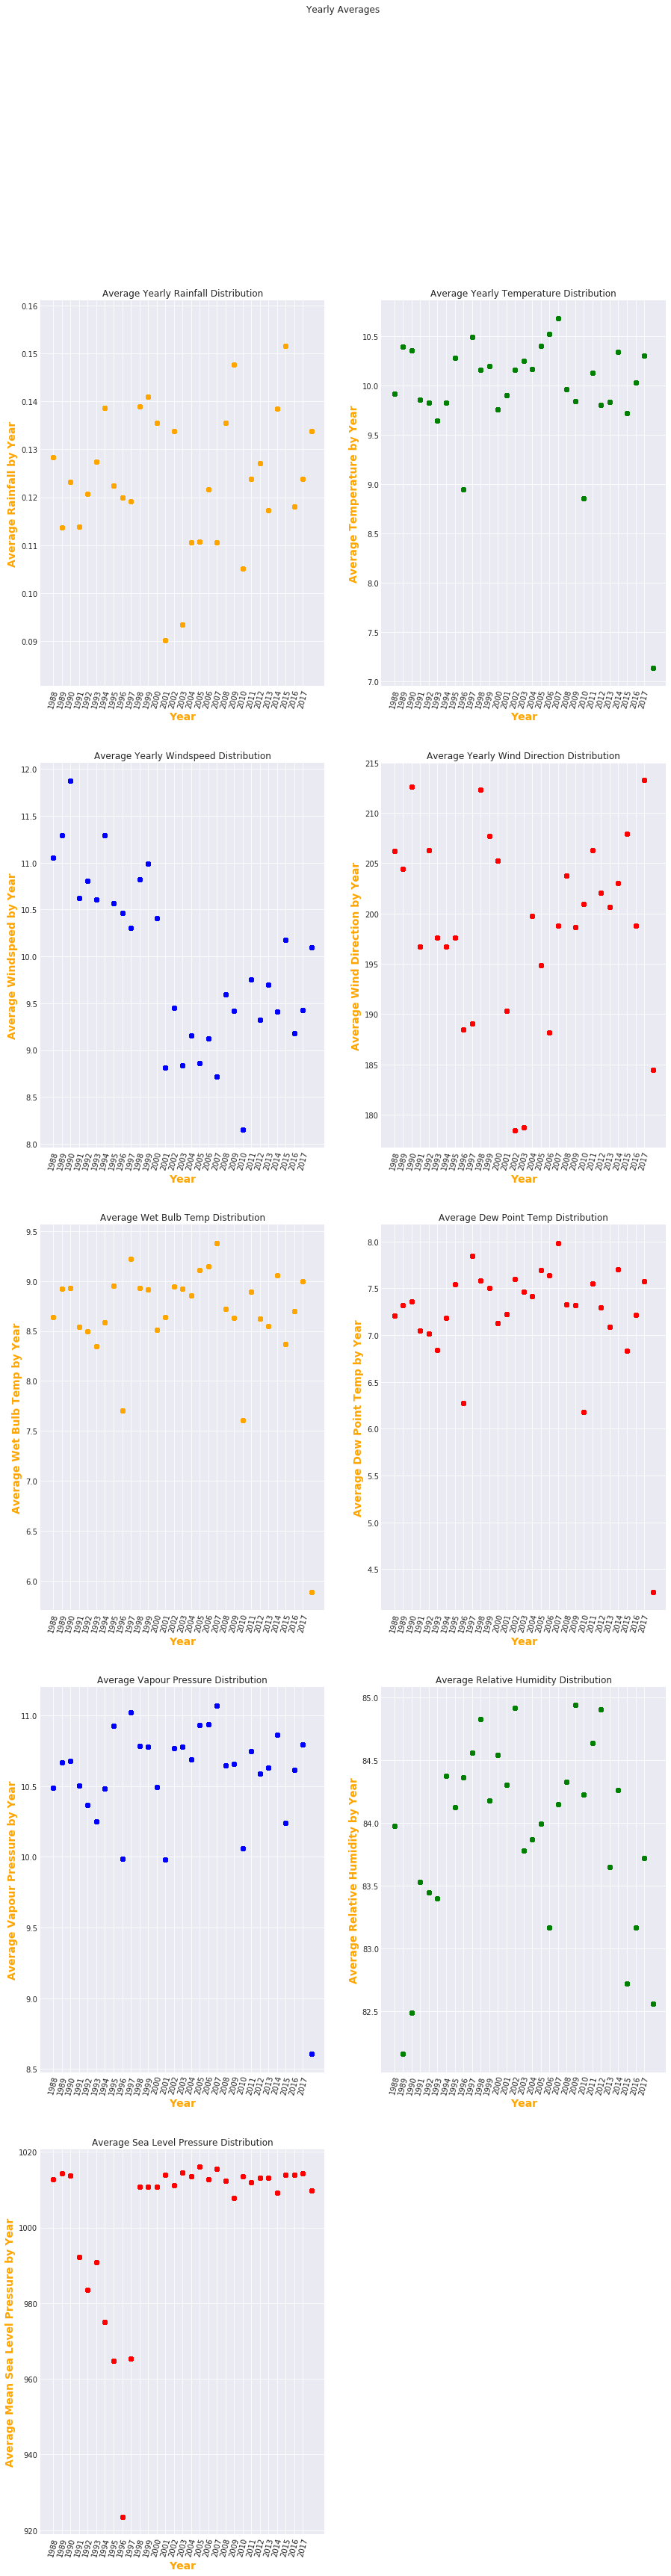

CPU times: user 4min 41s, sys: 700 ms, total: 4min 42s
Wall time: 4min 41s


In [31]:
%time plot_by_year(data)

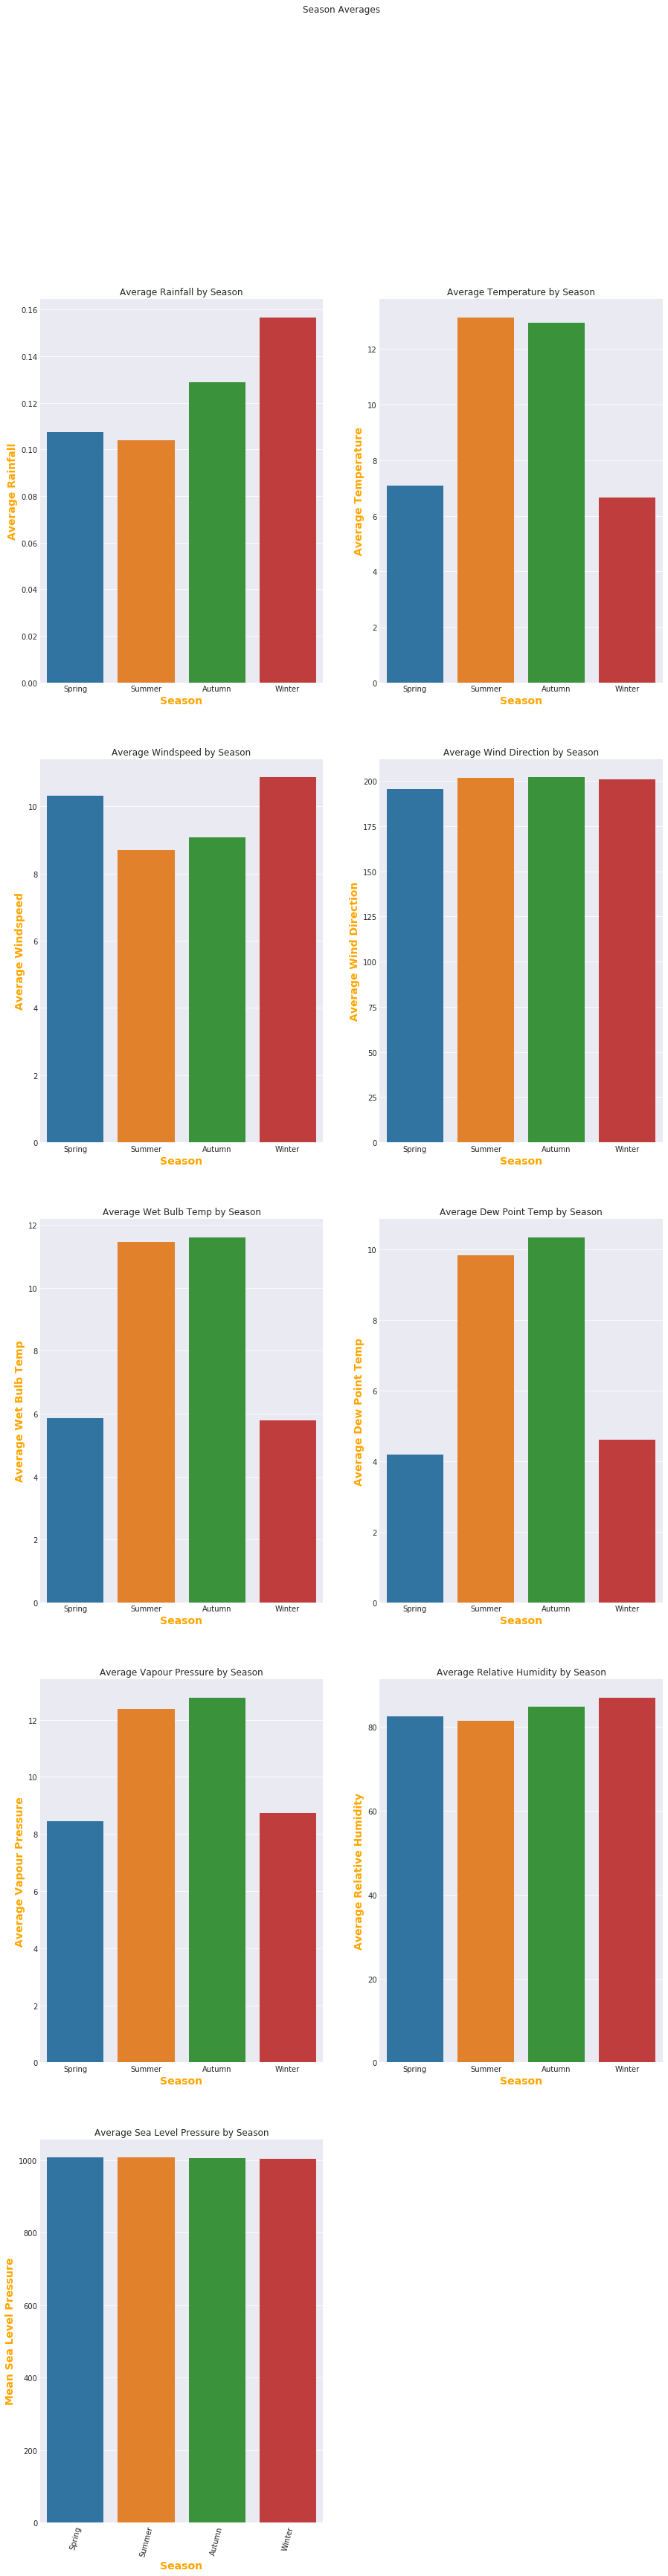

CPU times: user 6min 15s, sys: 860 ms, total: 6min 16s
Wall time: 6min 16s


In [32]:
%time plot_by_season(data)

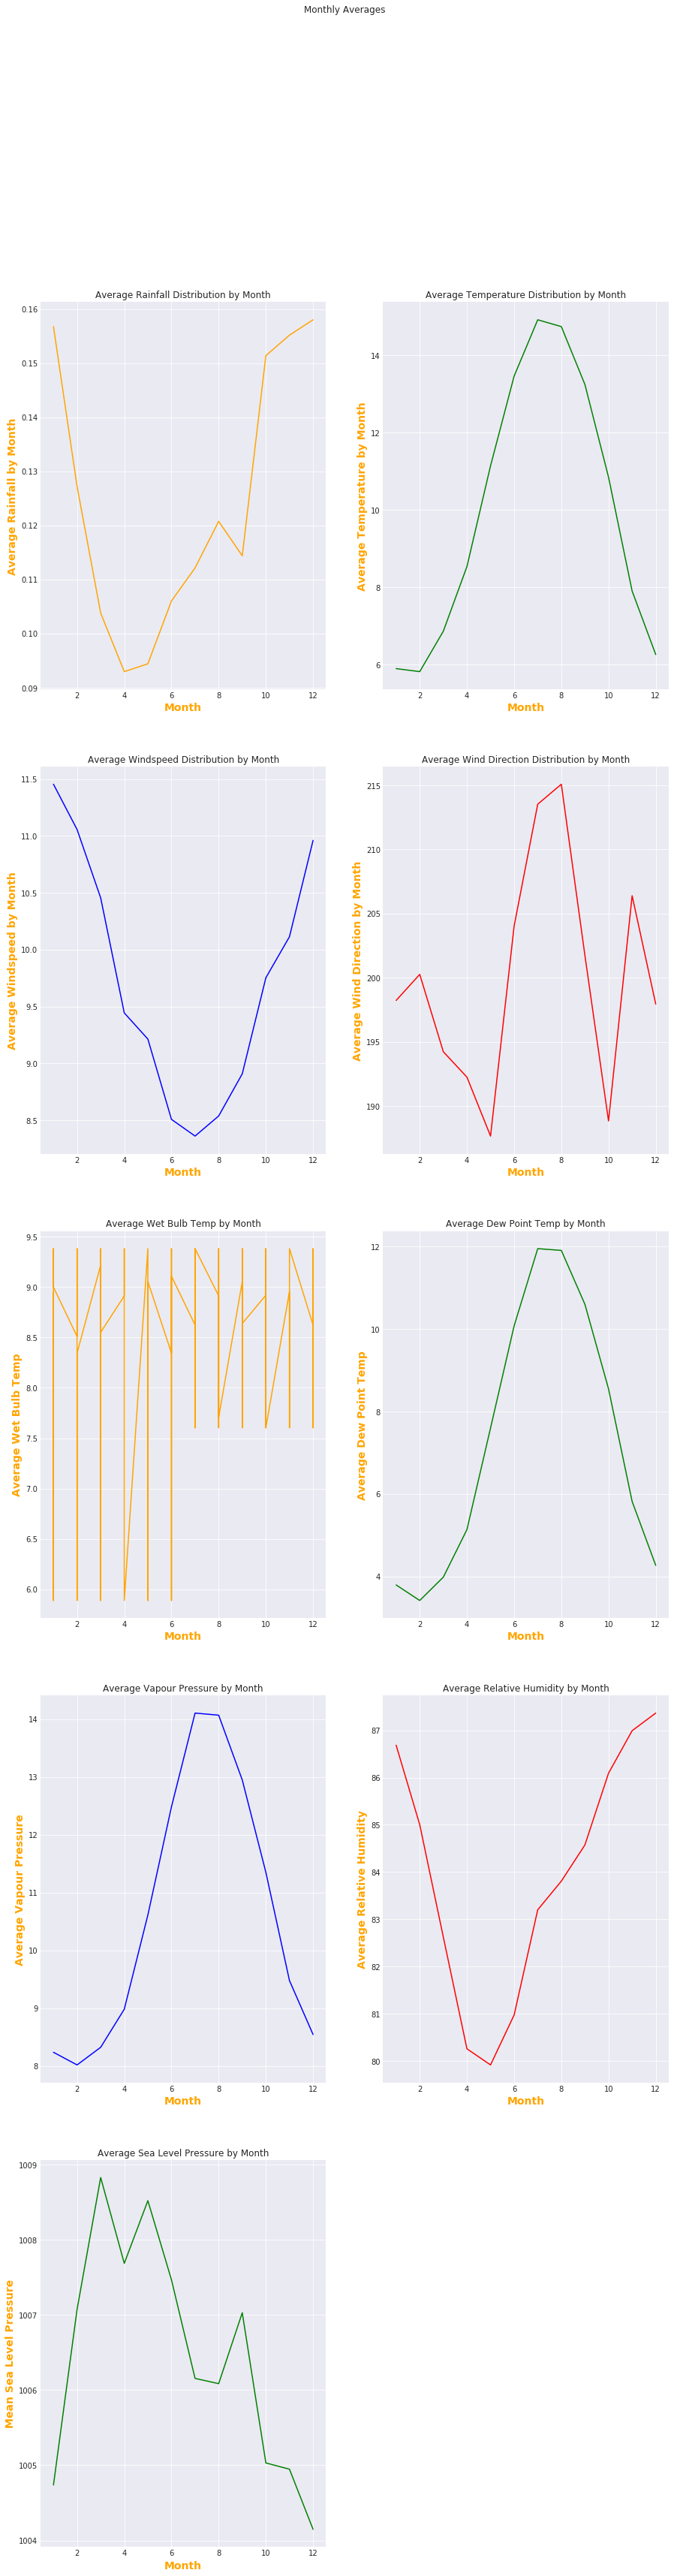

CPU times: user 8.31 s, sys: 1.14 s, total: 9.45 s
Wall time: 9.44 s


In [33]:
%time plot_by_month(data)

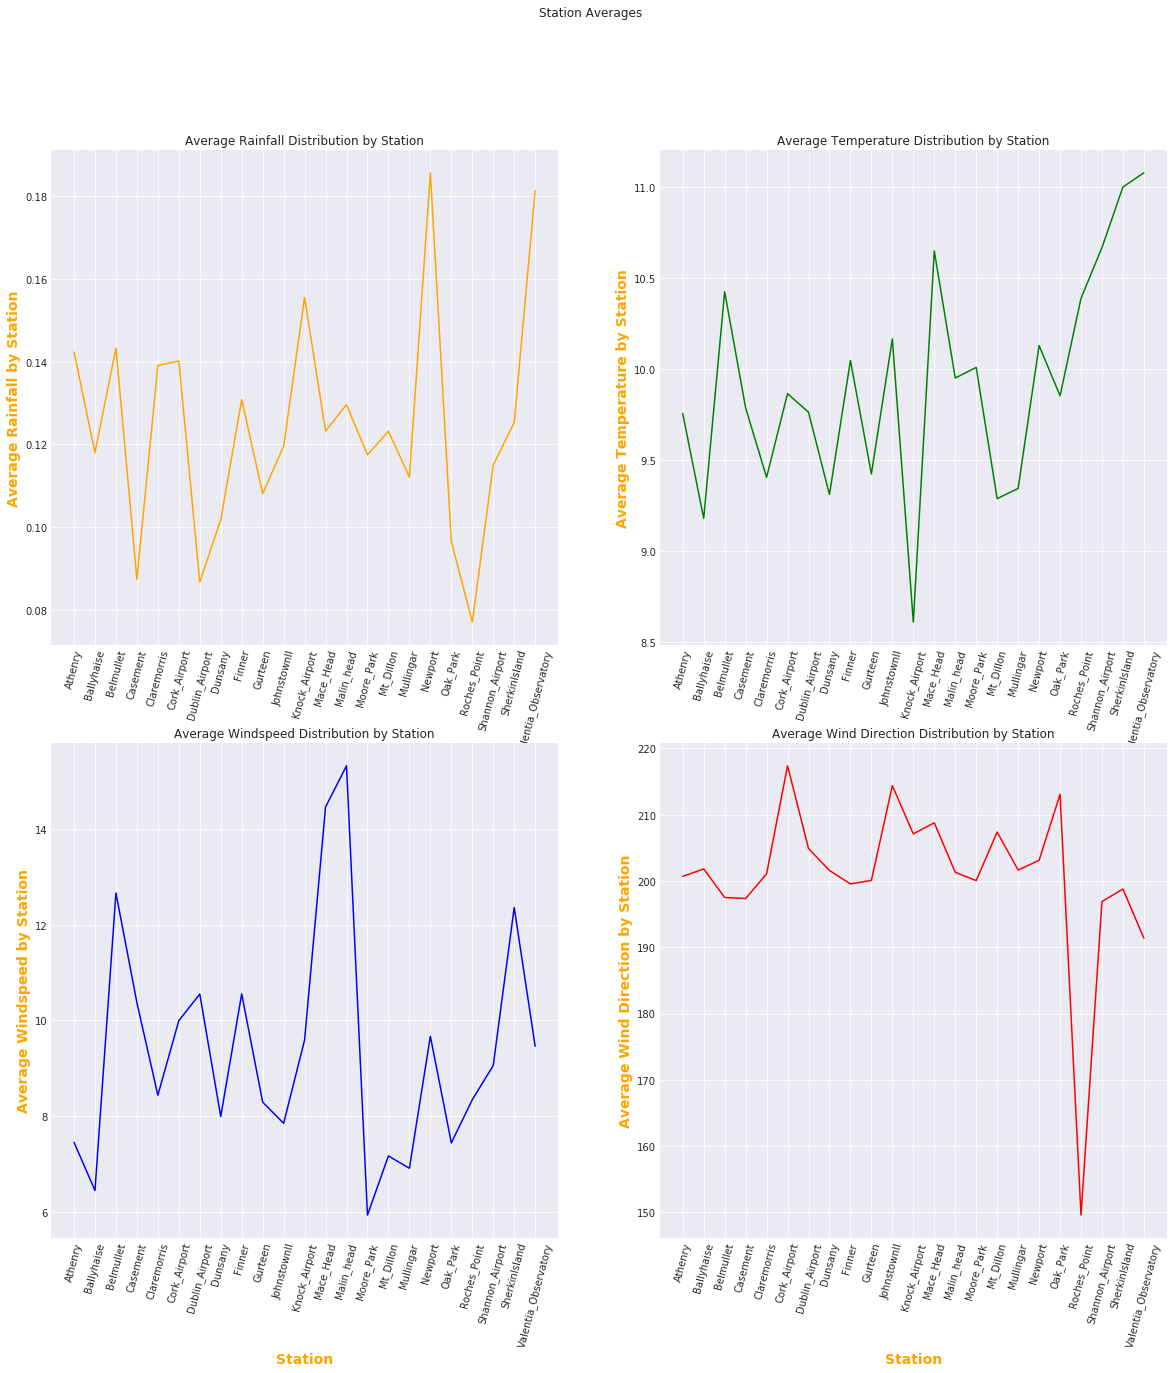

CPU times: user 2min 54s, sys: 4.26 s, total: 2min 58s
Wall time: 2min 57s


In [34]:
%time plot_by_station(data)

Extracting Data
Extracted Data
date         0
rain         0
temp         0
wetb         0
dewpt        0
vappr        0
rhum         0
msl          0
wdsp         0
wddir        0
height       0
latitude     0
longitude    0
station      0
county       0
dtype: int64
Removing relative humidity values <= 0


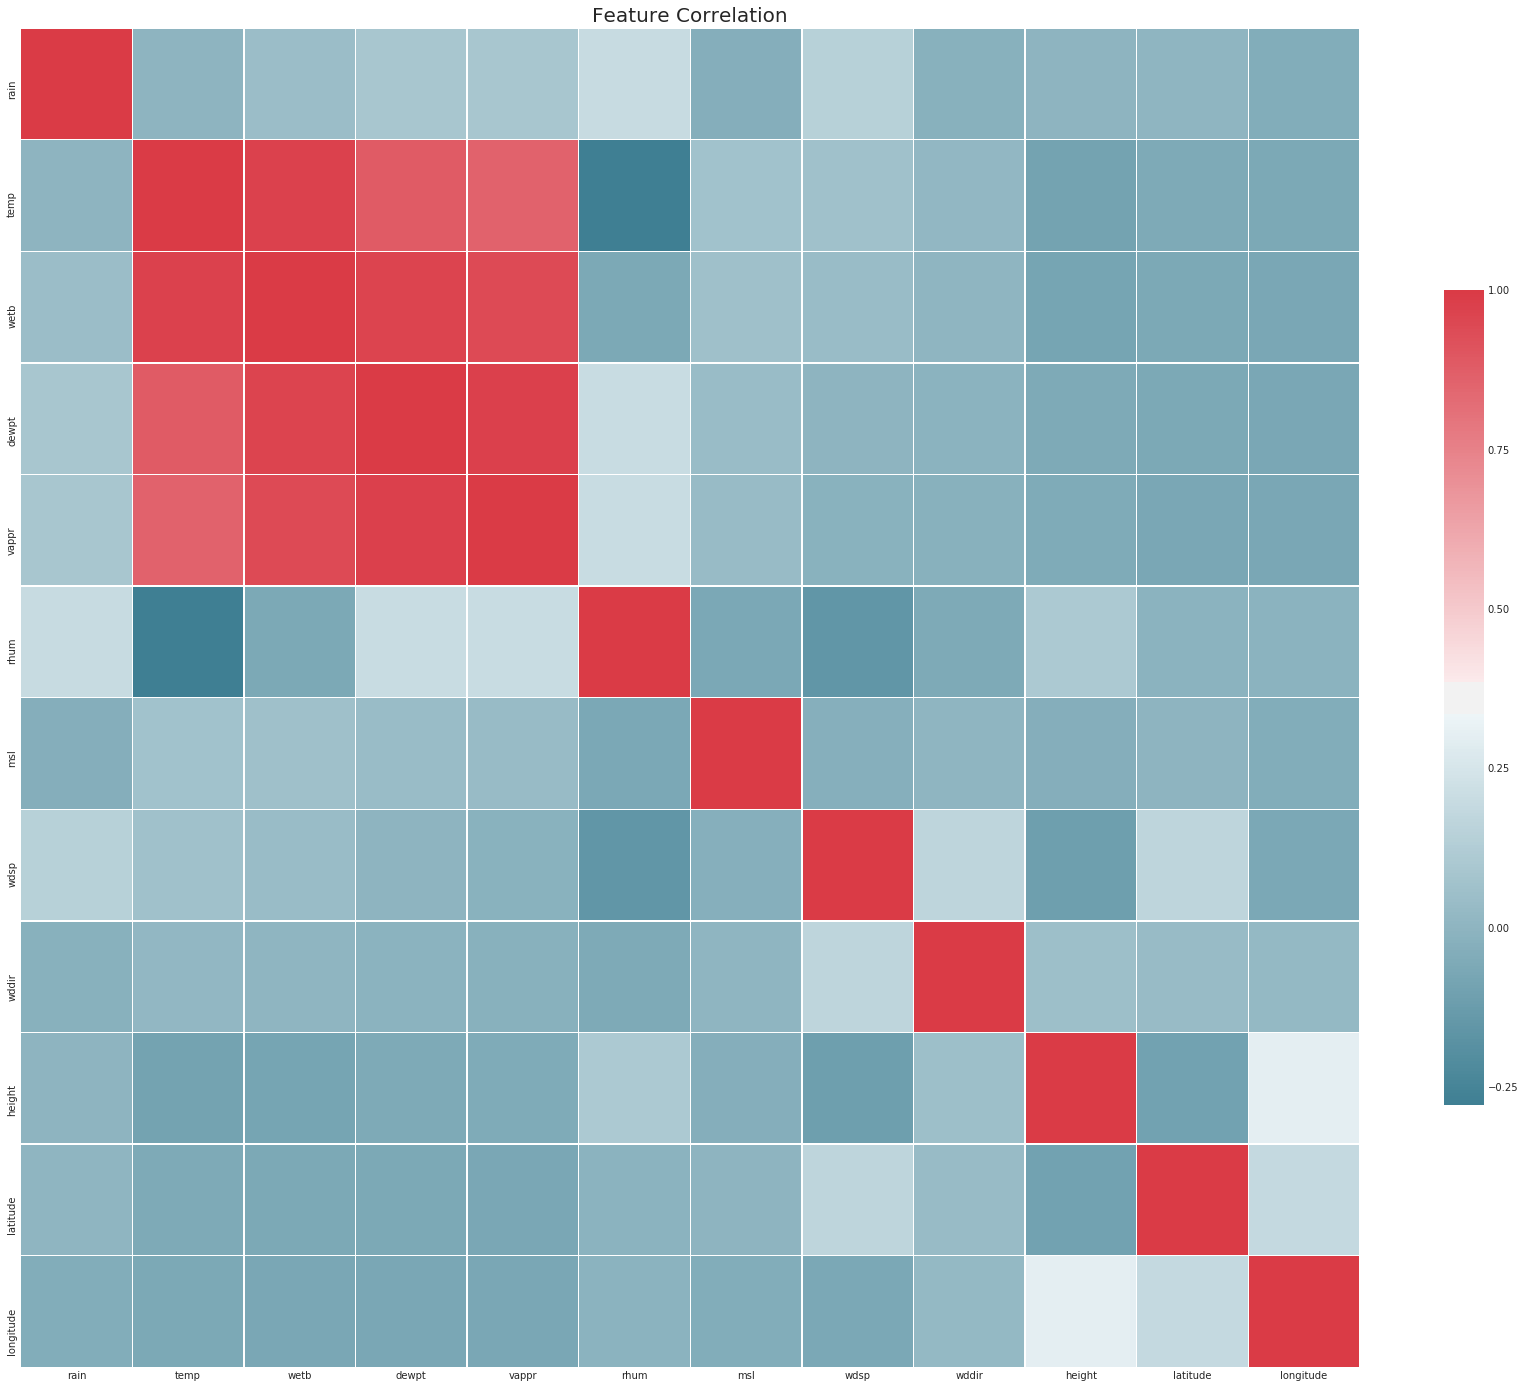

CPU times: user 1.62 s, sys: 144 ms, total: 1.77 s
Wall time: 1.82 s


In [35]:
data = select_data()
data = change_structure(data)
data = remove_rhum_values(data)

%time display_feature_correlations(data)

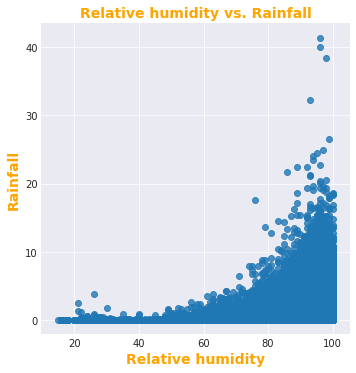

CPU times: user 40 s, sys: 216 ms, total: 40.2 s
Wall time: 40.3 s


In [36]:
%time rhum_vs_rain(data)

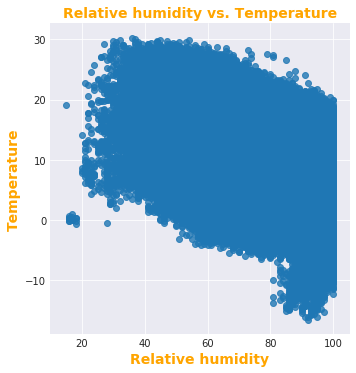

CPU times: user 40 s, sys: 168 ms, total: 40.2 s
Wall time: 40.2 s


In [37]:
%time rhum_vs_temp(data)

Humidity increases as evaporation takes place, so rhum vs temp may be useful  PG 42

Dewpoint determines how much water vapour the atmosphere can hold. Max amount of vapour atmosphere can hold is dependent on the temp. By increasing/decreasing temp can change amount of water vapour air can hold